Epoch 1/10 - Loss: 69462.4766, MAE: 191.5327, RMSE: 263.9713
Epoch 2/10 - Loss: 69453.1797, MAE: 191.5110, RMSE: 263.9538
Epoch 3/10 - Loss: 69443.8750, MAE: 191.4892, RMSE: 263.9363
Epoch 4/10 - Loss: 69434.5625, MAE: 191.4674, RMSE: 263.9188
Epoch 5/10 - Loss: 69425.2344, MAE: 191.4456, RMSE: 263.9013
Epoch 6/10 - Loss: 69415.8984, MAE: 191.4238, RMSE: 263.8838
Epoch 7/10 - Loss: 69406.5547, MAE: 191.4019, RMSE: 263.8662
Epoch 8/10 - Loss: 69397.1953, MAE: 191.3800, RMSE: 263.8485
Epoch 9/10 - Loss: 69387.8125, MAE: 191.3581, RMSE: 263.8309
Epoch 10/10 - Loss: 69378.4062, MAE: 191.3361, RMSE: 263.8132


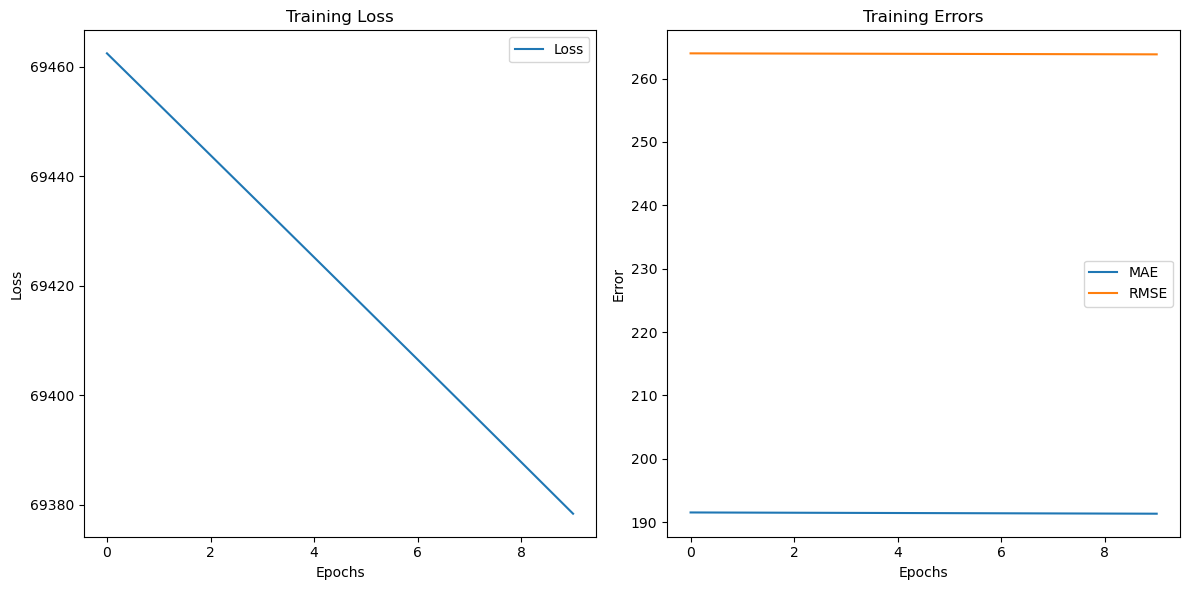

Prediction complete! Submission saved to 'submission.csv'


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
train_path = "C:/Users/raman/OneDrive/Desktop/bike-sharing-demand/train.csv"
test_path = "C:/Users/raman/OneDrive/Desktop/bike-sharing-demand/test.csv"
sample_submission_path = "C:/Users/raman/OneDrive/Desktop/bike-sharing-demand/sampleSubmission.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
sample_submission_df = pd.read_csv(sample_submission_path)

# Preprocessing the data

# Preprocessing the data
def preprocess_data(df, is_train=True):
    # Convert datetime to datetime object
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Extract year, month, day, hour from datetime
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.weekday

    # Drop the datetime column (no longer needed)
    df.drop(['datetime'], axis=1, inplace=True)

    if is_train:
        # For training data, drop target columns: count, casual, and registered
        features = df.drop(['count', 'casual', 'registered'], axis=1)
    else:
        # For testing data, drop only 'count', since test data doesn't contain it
        features = df.drop(['count'], axis=1, errors='ignore')  # Avoid dropping 'count' if it's not in test

    # Normalize numeric columns (excluding target column 'count' for now)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # If it's training data, include the 'count' column as the target
    if is_train:
        scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
        scaled_df['count'] = df['count']  # Add the target column back
        return scaled_df
    else:
        # If it's test data, return only the features
        return pd.DataFrame(scaled_features, columns=features.columns)

# Preprocess train and test data
train_data = preprocess_data(train_df, is_train=True)
test_data = preprocess_data(test_df, is_train=False)

# Split the data into training and validation sets
X = train_data.drop(['count'], axis=1).values
y = train_data['count'].values

# Split into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Define model (using BaselineMLP)
class BaselineMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BaselineMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        return self.fc2(x)

# Initialize the model
input_size = X_train.shape[1]  # Number of features
hidden_size = 64  # Example hidden size
output_size = 1  # Output size for regression task
model = BaselineMLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Training the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

epochs = 10
losses = []
maes = []
rmses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = model(X_train_tensor)
    
    # Compute loss
    loss = loss_fn(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # Compute metrics on validation set
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val_tensor)
        mae = mean_absolute_error(y_val_tensor.numpy(), y_val_pred.numpy())
        rmse = np.sqrt(mean_squared_error(y_val_tensor.numpy(), y_val_pred.numpy()))
    
    losses.append(loss.item())
    maes.append(mae)
    rmses.append(rmse)
    
    print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss.item():.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# Plot training metrics
def plot_training_metrics(losses, maes, rmses):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(maes, label='MAE')
    plt.plot(rmses, label='RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Training Errors')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_metrics(losses, maes, rmses)

# Make predictions on test set
X_test = test_data.values
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor).numpy()

# Prepare final submission
sample_submission_df['count'] = test_predictions
sample_submission_df.to_csv("submission.csv", index=False)

print("Prediction complete! Submission saved to 'submission.csv'")
